In [46]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.functional import binary_cross_entropy_with_logits
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import PowerTransformer, StandardScaler

In [48]:
def read_csv_pgbar(csv_path, index_col=None, chunksize=1024):
    rows = sum(1 for _ in open(csv_path, 'r')) - 1
    chunk_list = []
    with tqdm(total=rows, desc=f'Reading {csv_path}') as pbar:
        for chunk in pd.read_csv(csv_path, index_col=index_col, chunksize=chunksize):
            chunk_list.append(chunk)
            pbar.update(len(chunk))
    df = pd.concat((f for f in chunk_list), axis=0)
    return df

Create dataset

In [85]:
class CustomDataset(Dataset):
    def __init__(self):
        self.client_feat = read_csv_pgbar('client_feat.csv', index_col=0)
        self.scaler = StandardScaler()
        self.client_feat.loc[:, :] = self.scaler.fit_transform(self.client_feat.values)
        self.av_friends = read_csv_pgbar('av_friends.csv', index_col=0)
        self.fscaler = StandardScaler()
        self.av_friends.loc[:, :] = self.fscaler.fit_transform(self.av_friends.values)
        self.seq = read_csv_pgbar('full_seq.csv', index_col=0)
        self.target = read_csv_pgbar('target.csv', index_col=0)

    def __len__(self):
        return self.client_feat.shape[0]

    def __getitem__(self, idx):
        client_feat = self.client_feat.loc[idx].values
        seq = self.seq.loc[idx, 'seq']
        av_friends = self.av_friends.loc[idx].values
        if self.target.loc[idx, 'TARGET'] == 'test':
            target = 0
        else:    
            target = int(self.target.loc[idx, 'TARGET'])
        return client_feat, seq, av_friends, target

In [86]:
dataset = CustomDataset()

Reading /content/drive/My Drive/kda/client_feat.csv:   0%|          | 0/159288 [00:00<?, ?it/s]

Reading /content/drive/My Drive/kda/av_friends.csv:   0%|          | 0/159288 [00:00<?, ?it/s]

Reading /content/drive/My Drive/kda/full_seq.csv:   0%|          | 0/159290 [00:00<?, ?it/s]

Reading /content/drive/My Drive/kda/target.csv:   0%|          | 0/159290 [00:00<?, ?it/s]

In [56]:
client_feat, seq, agg_friends, target = dataset[1770023]
client_feat, seq, agg_friends, target

(array([-0.02227761, -0.16823854, -0.10366985, ...,  0.        ,
        -0.00405247, -0.004776  ]),
 'start_state f3855a04daf5e83747107e0c98254db9 dd253659a9e69f90b62669f71daf8de2 087fb4faeb7b8f13779ab9cbab5452f8 cfaebc0021cc3729028be60c8dbf6ec8 d694f3b60c35b806451e8d91cac8f579 a4dc4b63f821b701b2f74998edb96142 7bf1581c7ad0f7dd5d2ef00bd4ce2efb f3855a04daf5e83747107e0c98254db9 6a991ae854f6fd063e804ea04372b00b 85ebc9a87819b39b7a2cfe2f3f6482af a4dc4b63f821b701b2f74998edb96142 ed6da3582ac43aa6b4afab544dca1998 9b949b020d1f8e7b1f0be80a1d5f63a2 203250424d9841c0fe4ca8c1b56b3f08 c5395c7dcc1ba883953e199a1ee469c3 6a991ae854f6fd063e804ea04372b00b f3855a04daf5e83747107e0c98254db9 cfaebc0021cc3729028be60c8dbf6ec8 6a991ae854f6fd063e804ea04372b00b 5d91dec10f79029a60c812c3d1b9fde1 d4006bf8adccd7c134a61dc93fe06756 b6486c2402c646e280af20bb4115c4bd 43161dbb858384beb22bd762ab062ffc c5395c7dcc1ba883953e199a1ee469c3 b6486c2402c646e280af20bb4115c4bd a4dc4b63f821b701b2f74998edb96142 f3855a04daf5e83747107e0c982

In [57]:
private_idx = dataset.target[dataset.target['TARGET'] == 'test'].index.values
_public_idx = dataset.target[dataset.target['TARGET'] != 'test'].index.values
public_idx = _public_idx[(_public_idx != 86181) & (_public_idx != 84024)]
np.random.seed(1)
mask = np.random.choice(['train', 'test'], size=len(public_idx), p=[0.8, 0.2])
train_idx = public_idx[mask == 'train']
test_idx = public_idx[mask == 'test']
len(train_idx), len(test_idx)

(101897, 25533)

In [58]:
public_dataset = Subset(dataset, public_idx)
private_dataset = Subset(dataset, private_idx)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

Create dataloader

In [60]:
tokenizer = get_tokenizer(None)

def yield_tokens(data_iter):
    for _, text, _, _ in tqdm(data_iter):
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(public_dataset), 
    min_freq=64, 
    specials=['unknown'], 
    special_first=True)
vocab.set_default_index(0)
len(vocab)

  0%|          | 0/127430 [00:00<?, ?it/s]

5872

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [87]:
def collate_batch(batch):
    client_feat_list, seq_list, agg_friends_list, target_list = [], [], [], []
    for client_feat, seq, agg_friends, target in batch:
        client_feat_list.append(client_feat)
        processed_seq = torch.LongTensor(vocab(tokenizer(seq)))
        seq_list.append(processed_seq.to(device))
        agg_friends_list.append(agg_friends)
        target_list.append(target)
    client_feat_list = torch.FloatTensor(np.array(client_feat_list))
    agg_friends_list = torch.FloatTensor(np.array(agg_friends_list))
    target_list = torch.FloatTensor(target_list)[:, None]
    return client_feat_list.to(device), seq_list, agg_friends_list.to(device), target_list.to(device)

In [88]:
public_loader = DataLoader(public_dataset, batch_size=1024, collate_fn=collate_batch, shuffle=True)
private_loader = DataLoader(private_dataset, batch_size=1024, collate_fn=collate_batch)
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=collate_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, collate_fn=collate_batch)
for client_feat, seq_list, agg_friends, target in train_loader:
    break

In [89]:
client_feat.shape, len(seq_list), agg_friends.shape, target.shape

(torch.Size([1024, 1014]),
 1024,
 torch.Size([1024, 1014]),
 torch.Size([1024, 1]))

Create the model

In [115]:
class FullModel(nn.Module):
    def __init__(self, vocab_size, lstm_in, lstm_hid, mlp_in, mlp_hid, mlp_out, gcn_in, gcn_hid, gcn_out, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(mlp_in, mlp_hid),
            nn.Dropout(p=0.4),
            nn.ReLU(), 
            nn.Linear(mlp_hid, mlp_hid),
            nn.Dropout(p=0.4),
            nn.ReLU(), 
            nn.Linear(mlp_hid, mlp_out)
        )
        self.gcn = nn.Sequential(
            nn.Linear(gcn_in, gcn_hid),
            nn.Dropout(p=0.4),
            nn.ReLU(), 
            nn.Linear(gcn_hid, gcn_hid),
            nn.Dropout(p=0.4),
            nn.ReLU(), 
            nn.Linear(gcn_hid, gcn_out)
        )
        self.emb_layer = nn.Embedding(vocab_size, lstm_in)
        self.lstm = nn.LSTM(lstm_in, lstm_hid, batch_first=True)
        self.proj_head = nn.Linear(lstm_hid + mlp_out + gcn_out, out_dim)

    def forward(self, seq_list, client_feat, agg_friends):
        #LSTM
        lstm_list = []
        for seq in seq_list:
            seq_emb = self.emb_layer(seq)[None, ...]
            out, _ = self.lstm(seq_emb)
            lstm_list.append(out[0, -1])
        lstm_emb = torch.stack(lstm_list)
        
        #MLP
        client_emb = self.mlp(client_feat)
        
        #GCN
        friends_emb = self.gcn(agg_friends)
        
        return self.proj_head(torch.cat([lstm_emb, client_emb, friends_emb], dim=1))

In [116]:
full_model = FullModel(
    vocab_size=len(vocab), 
    lstm_in=64, 
    lstm_hid=32, 
    mlp_in=1014, 
    mlp_hid=64,
    mlp_out=32,
    gcn_in=1014,
    gcn_hid=64,
    gcn_out=32,
    out_dim=1
)
full_model.to(device)

FullModel(
  (mlp): Sequential(
    (0): Linear(in_features=1014, out_features=64, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (gcn): Sequential(
    (0): Linear(in_features=1014, out_features=64, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (emb_layer): Embedding(5872, 64)
  (lstm): LSTM(64, 32, batch_first=True)
  (proj_head): Linear(in_features=96, out_features=1, bias=True)
)

In [117]:
opt = torch.optim.Adam(full_model.parameters(), lr=0.001)

In [118]:
def train(full_model, train_loader, opt):
    full_model.train()
    losses = []
    for client_feat, seq_list, agg_friends, target in tqdm(train_loader, leave=False):
        logits = full_model(seq_list, client_feat, agg_friends)
        weight = torch.zeros_like(target)
        weight[target == 1] = 0.73
        weight[target == 0] = 0.27
        loss = binary_cross_entropy_with_logits(logits, target, weight)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [119]:
def evaluate(full_model, test_loader):
    full_model.eval()
    pred_list, target_list = [], []
    for client_feat, seq_list, agg_friends, target in tqdm(test_loader, leave=False):
        with torch.no_grad():
            pred = torch.sigmoid(full_model(seq_list, client_feat, agg_friends))
        pred_list.append(pred.cpu().numpy())
        target_list.append(target.cpu().numpy())
    pred = np.concatenate(pred_list)
    target = np.concatenate(target_list)
    fpr, tpr, _ = roc_curve(target.ravel(), pred.ravel())
    return fpr, tpr

In [120]:
def predict(full_model, private_loader):
    full_model.eval()
    pred_list = []
    for client_feat, seq_list, agg_friends, target in tqdm(private_loader, leave=False):
        with torch.no_grad():
            pred = torch.sigmoid(full_model(seq_list, client_feat, agg_friends))
        pred_list.append(pred.cpu().numpy())
    pred = np.concatenate(pred_list)
    return pred.ravel()

In [121]:
train_loss, test_loss = [], []

In [122]:
n_epochs = 6
for e in trange(n_epochs):
    train_loss.append(train(full_model, train_loader, opt))
    fpr, tpr = evaluate(full_model, test_loader)
    test_loss.append(auc(fpr, tpr))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

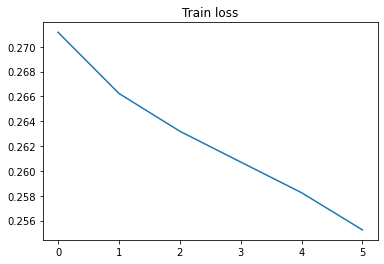

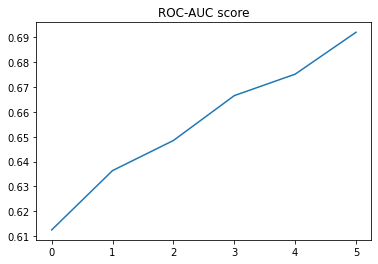

In [123]:
plt.plot(train_loss)
plt.title('Train loss')
plt.show()

plt.plot(test_loss)
plt.title('ROC-AUC score')
plt.show()

In [124]:
pred = predict(full_model, private_loader)
pd.DataFrame({
    'CLIENT_ID': private_idx,
    'TARGET': pred
}).to_csv('private_pred25_10_08.csv', index=False)

  0%|          | 0/32 [00:00<?, ?it/s]

MLP

  0%|          | 0/25 [00:00<?, ?it/s]

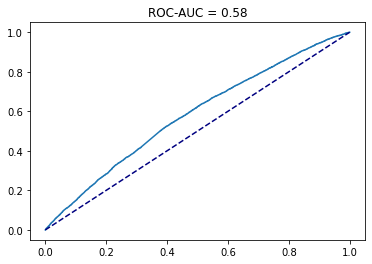

In [ ]:
fpr, tpr = evaluate(full_model, test_loader)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title(f'ROC-AUC = {auc(fpr, tpr):.2f}')
plt.show()

LSTM

  0%|          | 0/25 [00:00<?, ?it/s]

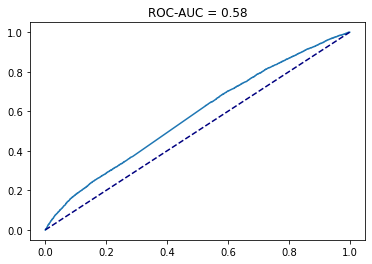

In [ ]:
fpr, tpr = evaluate(full_model, test_loader)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title(f'ROC-AUC = {auc(fpr, tpr):.2f}')
plt.show()

MLP + LSTM

  0%|          | 0/25 [00:00<?, ?it/s]

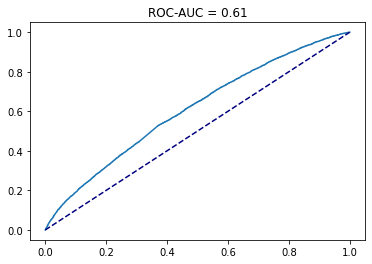

In [ ]:
fpr, tpr = evaluate(full_model, test_loader)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title(f'ROC-AUC = {auc(fpr, tpr):.2f}')
plt.show()

MLP + LSTM + GCN

  0%|          | 0/25 [00:00<?, ?it/s]

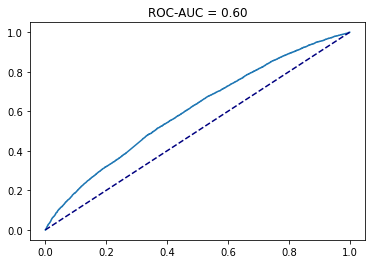

In [114]:
fpr, tpr = evaluate(full_model, test_loader)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title(f'ROC-AUC = {auc(fpr, tpr):.2f}')
plt.show()